# Линейная регрессия
__Суммарное количество баллов: 10__


In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from scipy.optimize import approx_fprime
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy

sns.set(style='whitegrid', font='serif')

# imports from other HWs
import nbimporter

from hw01 import read_cancer_dataset, read_spam_dataset

Importing Jupyter notebook from hw01.ipynb


In [2]:
def read_data(path="data/boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Ее и нужно реализовать.

In [4]:
def mse(y_true, y_predicted):
    return np.mean((y_true - y_predicted)**2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
def add_ones_column(arr):
    n, m = arr.shape
    new_arr = np.ones((n, m + 1))
    new_arr[:, 1:] = arr
    return new_arr

class NormalLR:
    def fit(self, X, y):
        X = add_ones_column(X)
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y
    
    def predict(self, X):
        X = add_ones_column(X)
        return X @ self.w

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.009713072958869294


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

### Задание 4 (2 балла)
Добавьте в метод `fit` регуляризацию Лассо с коэффициентом `l`. Постройте график зависимости ошибки предсказания данных из синтетического набора данных от коэффициента регуляризации.

In [8]:
class GradientLR:
    def __init__(self, alpha, iterations=10000, l=0., eps=1e-9):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.eps = eps
    
    def fit(self, X, y):
        X = add_ones_column(X)
        self.w = np.zeros(X.shape[1])
        
        for i in range(self.iterations):
            grad = 2/len(X) * (X.T @ ((X @ self.w) - y)) + self.l * np.sign(self.w)
            
            if sum(np.abs(grad)) * self.alpha < self.eps: break # if already converged
            self.w -= self.alpha * grad

    def predict(self, X):
        X = add_ones_column(X)
        return X @ self.w

In [9]:
def build_plot(X_train, y_train, X_test, y_test):
    ls = np.arange(0, 1, 0.01)
    errors = []
    for l in ls:
        regr = GradientLR(alpha=0.1, l=l)
        regr.fit(X_train, y_train)
        error = mse(y_test, regr.predict(X_test))
        errors.append(error)
        
    plt.plot(ls, errors)
    plt.xlabel("lasso coefficient")
    plt.ylabel("mse error")

In [10]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

0.009846812522529681


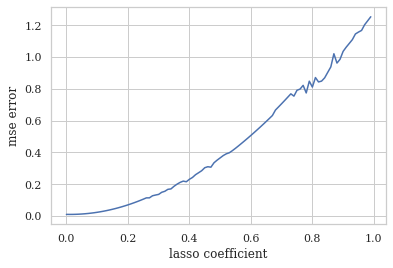

In [11]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)

### Задание 5 (2 балла)
Протесируйте оба метода на данных cancer и spam, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [12]:
X, y = read_spam_dataset('data/spam.csv')
X = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [13]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.24286362772250006


0.24505980083763676


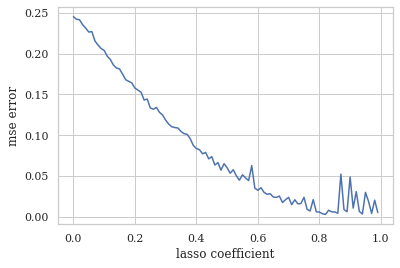

In [14]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)

In [15]:
X, y = read_cancer_dataset('data/cancer.csv')
X = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [16]:
regr = NormalLR()
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))

0.05991162426541535


0.08631594304747675


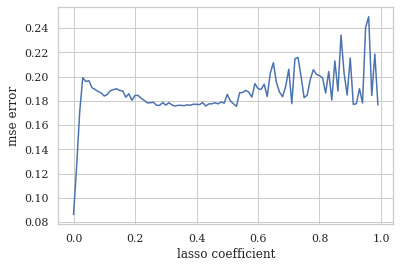

In [17]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
print(mse(y_test, regr.predict(X_test)))
build_plot(X_train, y_train, X_test, y_test)